# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd


features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
p=['right-x', 'right-y', 'left-x', 'left-y']
for feat,pos in zip(features_norm,p):
    df_mean= asl.df['speaker'].map(df_means[pos])
    df_st= asl.df['speaker'].map(df_std[pos])
    asl.df[feat]= (asl.df[pos]-df_mean)/df_st

In [12]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
asl.df['polar-rr'] = np.hypot(asl.df['grnd-rx'], asl.df['grnd-ry'])
asl.df['polar-lr'] = np.hypot(asl.df['grnd-lx'], asl.df['grnd-ly'])
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])

In [13]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
asl.df['delta-rx'] = asl.df['right-x'].fillna(0).diff().fillna(0)
asl.df['delta-ry'] = asl.df['right-y'].fillna(0).diff().fillna(0)
asl.df['delta-lx'] = asl.df['left-x'].fillna(0).diff().fillna(0)
asl.df['delta-ly'] = asl.df['left-y'].fillna(0).diff().fillna(0)

In [14]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

features_polar_norm = ['polar_norm-rr', 'polar_norm-rtheta', 'polar_norm-lr','polar_norm-ltheta']
features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

df_means_polar = asl.df.groupby('speaker').mean()
df_std_polar = asl.df.groupby('speaker').std()
for feat,pos in zip(features_polar_norm,features_polar):
    df_mean_polar= asl.df['speaker'].map(df_means_polar[pos])
    df_st_polar= asl.df['speaker'].map(df_std_polar[pos])
    asl.df[feat]= (asl.df[pos]-df_mean_polar)/df_st_polar
    
features_norm_grnd = ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx','norm-grnd-ly']
features_grnd = ['grnd-rx', 'grnd-ry', 'grnd-lx','grnd-ly']

df_std = asl.df.groupby('speaker').std()
df_mean = asl.df.groupby('speaker').mean()

for feature, root_feat in zip(features_norm_grnd, features_grnd):
    asl.df[feature] = (asl.df[root_feat] - asl.df['speaker'].map(df_means[root_feat])) / asl.df['speaker'].map(df_std[root_feat])

features_delta_norm_grnd = ['delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly']
asl.df[features_delta_norm_grnd] = asl.df[features_norm_grnd].fillna(0).diff().fillna(0)  

features_custom = features_norm_grnd + features_delta_norm_grnd + features_polar_norm

  


# TODO define a list named 'features_custom' for building the training set

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** The features are normalized with respect to nose-coordinates (features_norm_grnd) and also created delta features for the same (features_delta_norm_grnd) .The normalized features would be inpar to speaker's height and thus provide a better model. From the videos, by using the delta features we see the model is built well, and hence I applied delta to normalized grounded features also.
I also used polar co-ordinates of the features (features_polar) and normalized them (features_norm_polar).Since the length of arms and hands would vary person to person so(the length of r) , it would be much better to build a model with normalized features. 

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [15]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.136s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [16]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433223


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [17]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [18]:

my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]

hidden state #1
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #2
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073876   64.13103127   13.68077479  129.5912395 ]

logL = -601.3291470028632


In [19]:
for f in [features_norm_grnd,features_delta_norm_grnd ,features_polar_norm]:
    print("\n",f," :\n")
    my_testword = 'CHOCOLATE'
    model, logL = train_a_word(my_testword, 3,f) # Experiment here with different parameters
    show_model_stats(my_testword, model)
    print("logL = {}".format(logL))



 ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly']  :

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ 0.34911323  0.01768657 -0.0983817  -0.61135222]
variance =  [ 0.04192261  0.05595178  0.03091993  0.16873738]

hidden state #1
mean =  [ 0.33504838 -0.23255978 -0.44649782 -1.65918442]
variance =  [ 0.03611042  0.00449338  0.00155457  0.00676528]

hidden state #2
mean =  [ 0.99416385 -0.01517655 -1.2245362  -1.32713153]
variance =  [ 0.09675956  0.00738464  0.04416411  0.10880308]

logL = 52.47794393444913

 ['delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly']  :

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [  5.07275713e-11   4.32765288e-03   3.79068766e-20   4.03910010e-20]
variance =  [ 0.00050065  0.00086408  0.00050065  0.00050065]

hidden state #1
mean =  [ 0.12725589 -0.00349078 -0.04893487 -0.31701737]
variance =  [ 0.02509153  0.00398251  0.03315061  0.01393927]

##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [20]:
%matplotlib inline

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #1
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]

hidden state #2
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073876   64.13103127   13.68077479  129.5912395 ]

logL = -601.3291470028632


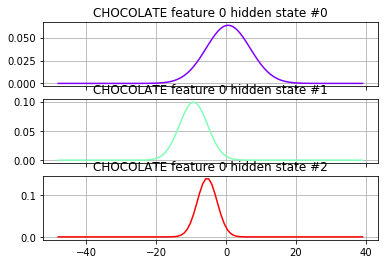

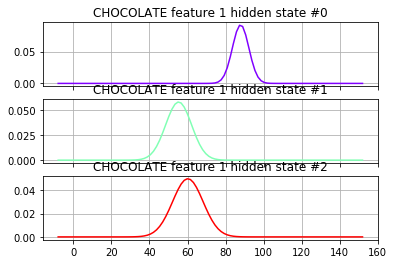

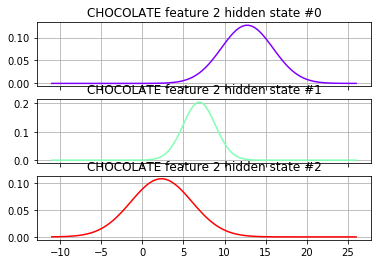

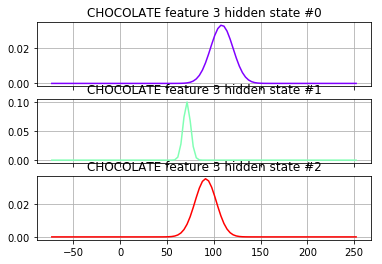

In [21]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))  
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [22]:
from my_model_selectors import SelectorConstant
for f in [features_norm_grnd,features_delta_norm_grnd ,features_polar_norm]:
    print("\nfeatures : ",f," :\n")
    training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
    for word in ['VEGETABLE', 'BOOK', 'FUTURE']: # Experiment here with different words
        model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
        print("\n Number of states trained in model for {} is {} \n".format(word, model.n_components))


features :  ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly']  :


 Number of states trained in model for VEGETABLE is 3 


 Number of states trained in model for BOOK is 3 


 Number of states trained in model for FUTURE is 3 


features :  ['delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly']  :


 Number of states trained in model for VEGETABLE is 3 


 Number of states trained in model for BOOK is 3 


 Number of states trained in model for FUTURE is 3 


features :  ['polar_norm-rr', 'polar_norm-rtheta', 'polar_norm-lr', 'polar_norm-ltheta']  :


 Number of states trained in model for VEGETABLE is 3 


 Number of states trained in model for BOOK is 3 


 Number of states trained in model for FUTURE is 3 



##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [23]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [24]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [25]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [26]:
cv = pd.DataFrame(columns=['Words', 'com', 'time',"feature"])
bic = pd.DataFrame(columns=['Words', 'com', 'time',"feature"])
dic = pd.DataFrame(columns=['Words', 'com', 'time',"feature"])
# cv=cv.append({'Words':word, 'com': model.n_components, 'time': end,"feature":feature[0].split("-")},ignore_index=True)
# cv

In [27]:
features[0].split("-r")[0]

NameError: name 'features' is not defined

In [28]:
# TODO: Implement SelectorCV in my_model_selector.py

from my_model_selectors import SelectorCV
for features in [features_ground,features_norm_grnd,features_delta_norm_grnd ,features_polar_norm]:
    print("\nfeatures : ",features," :\n")    
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorCV(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        cv=cv.append({'Words':word, 'com': model.n_components, 'time': end,"feature":features[0].split("-r")[0]},ignore_index=True)
        if model is not None:
            print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("Training failed for {}".format(word))


features :  ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']  :

Training complete for FISH with 3 states with time 0.03202981161139238 seconds
Training complete for BOOK with 3 states with time 0.13334859433665058 seconds
Training complete for VEGETABLE with 3 states with time 0.04386512128927811 seconds
Training complete for FUTURE with 3 states with time 0.09268560637499407 seconds
Training complete for JOHN with 3 states with time 1.5086282678404253 seconds

features :  ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly']  :

Training complete for FISH with 3 states with time 0.033015083404507095 seconds
Training complete for BOOK with 3 states with time 0.21041532240431593 seconds
Training complete for VEGETABLE with 3 states with time 0.05745990863032091 seconds
Training complete for FUTURE with 3 states with time 0.1898232311738539 seconds
Training complete for JOHN with 3 states with time 1.5859176637635066 seconds

features :  ['delta-norm-grnd-rx', 'delta-norm-grnd-r

In [29]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC
for features in [features_ground,features_norm_grnd,features_delta_norm_grnd ,features_polar_norm]:
    print("\nfeatures : ",features," :\n") 
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorBIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        bic=bic.append({'Words':word, 'com': model.n_components, 'time': end,"feature":features[0].split("-r")[0]},ignore_index=True)
        if model is not None:
            print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("Training failed for {}".format(word))


features :  ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']  :

Training complete for FISH with 5 states with time 0.9291826974135802 seconds
Training complete for BOOK with 8 states with time 3.578637451216096 seconds
Training complete for VEGETABLE with 15 states with time 1.8665684072242499 seconds
Training complete for FUTURE with 9 states with time 5.605552595575375 seconds
Training complete for JOHN with 14 states with time 48.11293142454771 seconds

features :  ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly']  :

Training complete for FISH with 3 states with time 0.9056432691389489 seconds
Training complete for BOOK with 10 states with time 3.6143954991642318 seconds
Training complete for VEGETABLE with 8 states with time 1.9000975454773368 seconds
Training complete for FUTURE with 7 states with time 6.168168670677375 seconds
Training complete for JOHN with 14 states with time 55.423505782670816 seconds

features :  ['delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'del

In [30]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC
for features in [features_ground,features_norm_grnd,features_delta_norm_grnd ,features_polar_norm]:
    print("\nfeatures : ",features," :\n") 
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorDIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        dic=dic.append({'Words':word, 'com': model.n_components, 'time': end,"feature":features[0].split("-r")[0]},ignore_index=True)

        if model is not None:
            print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("Training failed for {}".format(word))


features :  ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']  :

Training complete for FISH with 3 states with time 2.68995933076485 seconds
Training complete for BOOK with 15 states with time 10.954657417249223 seconds
Training complete for VEGETABLE with 15 states with time 7.937797132180833 seconds
Training complete for FUTURE with 15 states with time 11.12966007230682 seconds
Training complete for JOHN with 15 states with time 53.06103642739015 seconds

features :  ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly']  :

Training complete for FISH with 2 states with time 6.271915380860264 seconds
Training complete for BOOK with 15 states with time 10.18067689243128 seconds
Training complete for VEGETABLE with 9 states with time 6.927117553455901 seconds
Training complete for FUTURE with 15 states with time 12.180443961328137 seconds
Training complete for JOHN with 15 states with time 61.13620713197554 seconds

features :  ['delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta

**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**



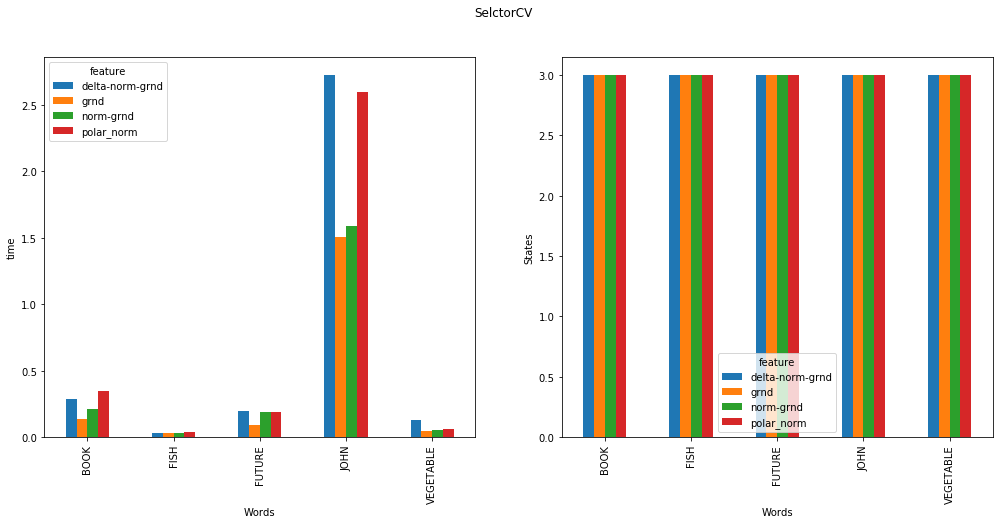

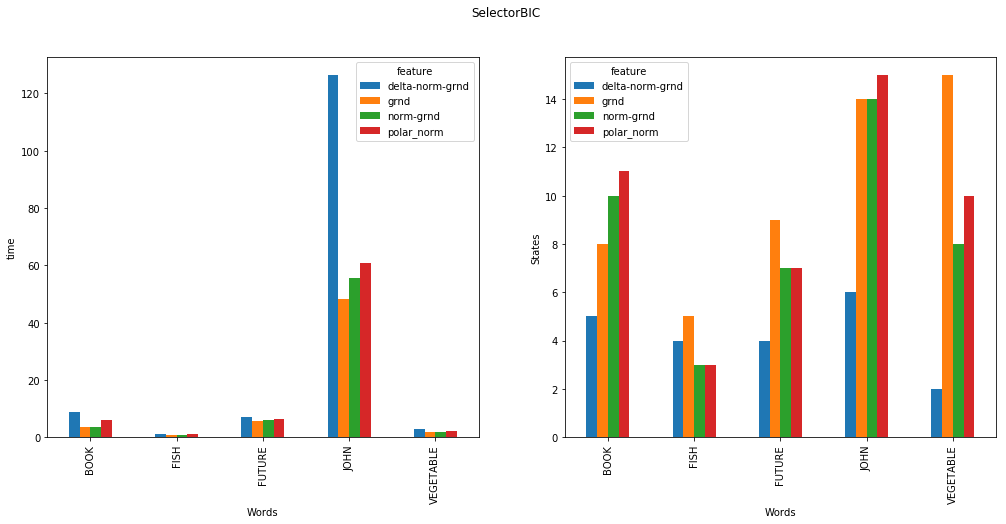

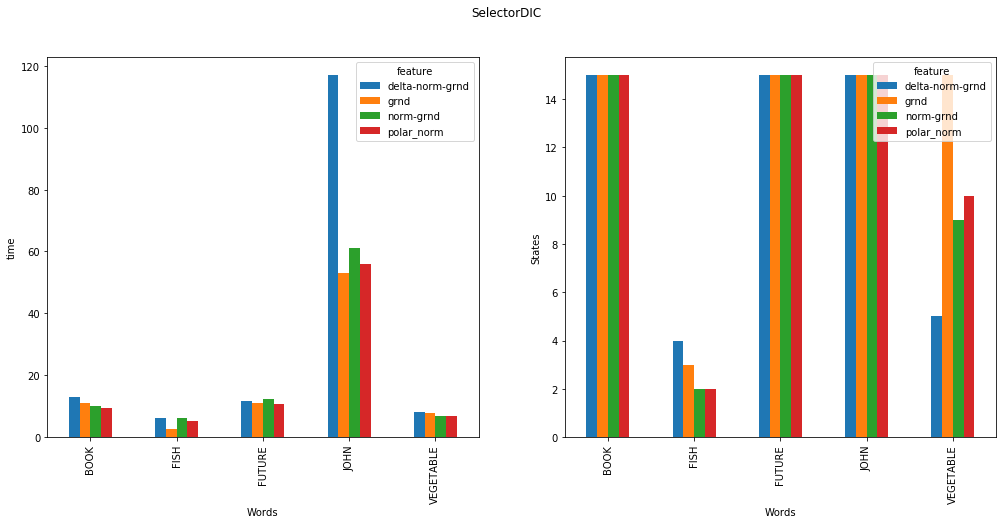

In [175]:
for df,title in zip([bic,dic,cv],["SelectorBIC","SelectorDIC","SelctorCV"]):
    fig, axes = plt.subplots(1,2,figsize=(17,7))
    pd.pivot_table(df,index="Words", columns=["feature"], values='time').plot(kind='bar',ax=axes[0]); axes[0].set_ylabel("time")#('A');
    pd.pivot_table(df,index="Words", columns=["feature"], values='com').plot(kind='bar',ax=axes[1]);axes[1].set_ylabel("States")
    plt.suptitle(title)
#below plot shows the comparision

Higher pre processing time is found in DIC as it generates mixture for all those possible words and range of states.
With high amount of words, the pre-processing time would skyrocket.Other model selecting strategy are agnostic to the performance of other models and try to improve performance by looking at various models for the same phrase.

By Enhancing within-class statistics BIC tries to select model that maximizes the gain. Inside the BIC formula, a penality term penalizes complexness to avoid overfitting, such that it is not essential to also use cross-validation in the process of Selection.

DIC being truly a discriminant selector capacity of an training set for just one word against competing words. Rather than a penality term for complexness, it offers a penality if model likelihoods for non-matching words are too very much like model likelihoods for the right word in the word collection. The competitive mother nature of DIC helps it be the best executing selection strategy in almost all of the cases.

CV allows to generate models that generalize well to new data through arbitrary sampling. More will be the volume of cross-validation place, the cross validation selector performance would be improvised . However, cross-validation selector wouldn't normally work very well if training data is not sufficient.



<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [176]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 47.545s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [177]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [178]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [179]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [180]:
# Experimenting with feature sets and model selectors
import my_model_selectors

features = features_custom
model_selector = my_model_selectors.SelectorDIC

# Recognize the test set and display the result with the show_errors method
print("\n")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)



Features: ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly', 'delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly', 'polar_norm-rr', 'polar_norm-rtheta', 'polar_norm-lr', 'polar_norm-ltheta']
Model Selector: <class 'my_model_selectors.SelectorDIC'>

**** WER = 0.4943820224719101
Total correct: 90 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *CAR GO CAN                                              JOHN CAN GO CAN
   12: *IX *HOUSE *ARRIVE *HOUSE                                     JOHN CAN GO CAN
   21: *MARY *NEW *JOHN *MARY *HOUSE *CAR *FUTURE *FUTURE            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *MARY IX IX                                        JOHN LIKE IX IX IX
   28: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   30: JOHN *MARY *LOV

In [181]:

# Experimenting with feature sets and model selectors
import my_model_selectors

features = features_custom
model_selector = my_model_selectors.SelectorBIC

# Recognize the test set and display the result with the show_errors method
print("----------------------------------")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

----------------------------------
Features: ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly', 'delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly', 'polar_norm-rr', 'polar_norm-rtheta', 'polar_norm-lr', 'polar_norm-ltheta']
Model Selector: <class 'my_model_selectors.SelectorBIC'>

**** WER = 0.5112359550561798
Total correct: 87 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *CAR GO CAN                                              JOHN CAN GO CAN
   12: *IX *CAR *ARRIVE *HOUSE                                       JOHN CAN GO CAN
   21: *MARY *CAR *JOHN *MARY *CAR *CAR *FUTURE *FUTURE              JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *MARY IX IX                                        JOHN LIKE IX IX IX
   28: JOHN *IX IX IX IX                                             JOHN LIK

In [183]:

# Experimenting with feature sets and model selectors
import my_model_selectors

features = features_custom
model_selector = my_model_selectors.SelectorCV

# Recognize the test set and display the result with the show_errors method
print("----------------------------------")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

----------------------------------
Features: ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly', 'delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly', 'polar_norm-rr', 'polar_norm-rtheta', 'polar_norm-lr', 'polar_norm-ltheta']
Model Selector: <class 'my_model_selectors.SelectorCV'>

**** WER = 0.5280898876404494
Total correct: 84 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *CAR GO CAN                                              JOHN CAN GO CAN
   12: JOHN *CAR *CAR *HOUSE                                         JOHN CAN GO CAN
   21: JOHN *VIDEOTAPE WONT *IX-1P *CAR *CAR *FUTURE *WHO            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   28: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

|Model Selector|Feature Set|Total|Correct|Incorrect|WER|
|------|-----------|
|SelectorDIC|features_custom|178|90|88|0.494|
|SelectorBIC|features_custom|178|87|91|0.511|
|SelectorCV|features_custom|178|84|94|0.528|

The best combinations is DIC with features_custom because it has the lowest WER.

The combination of model selector or features, it's hard to get a WER lower than 0.5.To improve our WER we use the probability of the word inside the set, and the probability of each word next to another one (using Statistical language model or SLM)

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [184]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 58.601s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()